# Hyperparameter Tuning, Final Model + Graphs

## Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sksurv.datasets import load_gbsg2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_ipcw
from sklearn.model_selection import GridSearchCV
from sksurv.linear_model import CoxPHSurvivalAnalysis
from matplotlib.lines import Line2D
from sksurv.metrics import concordance_index_censored
import random
set_config(display="text")  # displays text representation of estimators

In [2]:
pd.set_option('display.max_columns', 800)
pd.set_option('display.max_rows', 300)

## Loading the table created in the preprocessing notebook

In [3]:
kidpan_living = pd.read_csv('csv_data/final_kidpan_living.csv')

/var/tmp/pbs.185076.login1/ipykernel_188387/462418778.py:1: DtypeWarning: Columns (23,33,64,65,79,85,86,87,93,101,102,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  kidpan_living = pd.read_csv('csv_data/final_kidpan_living.csv')


## Handling features

#### Columns with highest variable importance calculated in the preprocessing notebook

In [4]:
best_columns = ["CREAT_TRR", "AGE", "AGE_DON", "PREV_TX_ANY", "ON_DIALYSIS", "END_BMI_CALC", "DIAB", 
                "WORK_INCOME_TCR", "PRI_PAYMENT_TCR_KI", "DAYSWAIT_CHRON_KI", "PRE_TX_TXFUS", "TOT_SERUM_ALBUM",
               "PERIP_VASC", "ETHCAT_DON", "ETHCAT", "FUNC_STAT_TCR", "HCV_SEROSTATUS", "HIST_CIG",
               "HLAMIS", "EBV_SEROSTATUS","DIABETES_DON", "DAYSWAIT_ALLOC", "KI_CREAT_PREOP", 'DIAG_KI' ]
target_columns = ["GTIME_KI", "GSTATUS_KI"]
len(best_columns)

24

In [5]:
kidpan_living = kidpan_living[best_columns + target_columns]
kidpan_living

,CREAT_TRR,AGE,AGE_DON,PREV_TX_ANY,ON_DIALYSIS,END_BMI_CALC,DIAB,WORK_INCOME_TCR,PRI_PAYMENT_TCR_KI,DAYSWAIT_CHRON_KI,PRE_TX_TXFUS,TOT_SERUM_ALBUM,PERIP_VASC,ETHCAT_DON,ETHCAT,FUNC_STAT_TCR,HCV_SEROSTATUS,HIST_CIG,HLAMIS,EBV_SEROSTATUS,DIABETES_DON,DAYSWAIT_ALLOC,KI_CREAT_PREOP,DIAG_KI,GTIME_KI,GSTATUS_KI
0,6.70,43.0,44.0,N,N,23.4,NaN,NaN,NaN,247.0,N,NaN,NaN,1,1,1.0,N,NaN,1.0,NaN,NaN,NaN,NaN,3011.0,5219.0,1.0
1,NaN,45.0,66.0,N,N,23.0,NaN,NaN,NaN,37.0,Y,NaN,NaN,1,1,998.0,N,NaN,2.0,NaN,NaN,NaN,NaN,3011.0,1459.0,0.0
2,NaN,43.0,19.0,N,NaN,27.8,NaN,NaN,NaN,689.0,Y,NaN,NaN,4,4,998.0,N,NaN,5.0,NaN,NaN,NaN,NaN,3040.0,5212.0,1.0
3,NaN,22.0,47.0,N,NaN,16.3,NaN,NaN,NaN,548.0,Y,NaN,NaN,5,5,998.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3041.0,2813.0,1.0
4,NaN,53.0,51.0,N,N,29.8,NaN,NaN,NaN,1738.0,Y,NaN,NaN,1,1,1.0,N,NaN,3.0,NaN,NaN,NaN,NaN,3012.0,1947.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173702,12.60,43.0,32.0,N,Y,27.6,1.0,Y,1.0,1.0,NaN,4.7,N,4,4,2070.0,N,N,NaN,P,N,505.0,1.00,999.0,3.0,0.0
173703,7.95,41.0,29.0,N,Y,18.0,1.0,N,2.0,6.0,NaN,1.5,N,1,2,2090.0,N,N,3.0,N,N,616.0,0.74,3016.0,7.0,0.0
173704,4.41,52.0,56.0,N,N,36.5,1.0,Y,1.0,4.0,NaN,4.1,N,9,4,2090.0,N,N,4.0,N,N,4.0,0.76,3040.0,4.0,0.0
173705,7.73,28.0,34.0,N,Y,21.0,1.0,Y,1.0,6.0,NaN,2.7,N,2,2,2100.0,ND,NaN,NaN,P,NaN,57.0,NaN,3018.0,4.0,0.0


#### Fixing data types - correcting categorical and numerical columns

In [6]:
original_categorical_cols = ['WL_ORG', 'GENDER_REC', 'ABO_REC', 'CITIZENSHIP_REC', 'PERM_STATE', 'FUNC_STAT_TCR', 'ETHNICITY',
               'ETHCAT', 'REGION_REC', 'DATA_WAITLIST', 'OPO_CTR_CODE', 'INIT_OPO_CTR_CODE', 'DONATION',
               'ON_DIALYSIS', 'EXH_PERIT_ACCESS', 'EXH_VASC_ACCESS', 'PREV_TX', 'PREV_KI_TX', 'MALIG_TRR',
               'PRE_TX_TXFUS', 'TXKID', 'DON_RETYP', 'HBV_CORE_DON', 'HBV_SUR_ANTIGEN_DON', 'ETHCAT_DON',
               'CITIZENSHIP_DON', 'ABO_DON', 'GENDER_DON', 'HOME_STATE_DON', 'CANCER_SITE_DON', 'HIST_CIG_DON',
               'HIST_HYPERTENS_DON', 'HIST_CANCER_DON', 'DIABETES_DON', 'END_STAT_KI', 'ABO_MAT', 'ORGAN',
               'CMV_IGG_REC', 'CMV_IGM_REC', 'HBV_CORE_REC', 'HBV_SUR_ANTIGEN_REC', 'HCV_SEROSTATUS',
               'HIV_SEROSTATUS', 'PREV_TX_ANY', 'AGE_GROUP', 'MALIG', 'LT_ONE_WEEK_DON', 'EDUCATION_REC', 'DIAB',
               'DRUGTRT_COPD', 'PERIP_VASC', 'MALIG_TCR_KI', 'PRI_PAYMENT_TCR_KI', 'HAPLO_TY_MATCH_DON',
               'CMV_TEST_DON', 'HBV_TEST_DON', 'HCV_TEST_DON', 'HCV_RIBA_DON', 'HCV_ANTIBODY_DON', 'LIV_DON_TY',
               'EBV_SEROSTATUS', 'EBV_TEST_DON', 'HCV_RNA_DON', 'EDUCATION_DON', 'HBV_DNA_DON', 'CMV_NUCLEIC_DON',
               'CMV_IGG_DON', 'CMV_IGM_DON', 'WORK_INCOME_TCR', 'EBV_IGG_DON', 'EBV_IGM_DON', 'DON_ORG',
               'HCV_ANTIBODY', 'HCV_RIBA', 'HOME_STATE', 'REGION_DON', 'VIRUSES_TESTED', 'CMV_NUCLEIC',
               'DIABETES', 'FUNC_STAT', 'HBV_DNA', 'HCV_RNA', 'HEALTH_INS', 'HIST_CANCER', 'HIST_CIG', 'HIST_HYPER',
               'MARITAL_STAT', 'NON_AUTO_BLOOD', 'READMISSION_KI', 'TOBACCO_USE', 'WORK_INCOME', 'EBV_IGG',
               'EBV_IGM', 'DIAG_KI']
original_numerical_cols = ['NUM_PREV_TX', 'WGT_KG_TCR', 'HGT_CM_TCR', 'BMI_TCR', 'INIT_WGT_KG', 'INIT_HGT_CM', 'DAYSWAIT_CHRON',
               'END_STAT', 'INIT_DATE', 'INIT_BMI_CALC', 'END_BMI_CALC', 'INIT_STAT', 'TX_DATE', 'AMIS', 'BMIS',
               'DRMIS', 'HLAMIS', 'NPKID', 'HGT_CM_DON_CALC', 'WGT_KG_DON_CALC', 'BMI_DON_CALC', 'CREAT1Y',
               'DIAL_DATE', 'AGE', 'DISTANCE', 'DAYSWAIT_CHRON_KI', 'HGT_CM_CALC', 'WGT_KG_CALC',
               'BMI_CALC', 'CREAT6M', 'TOT_SERUM_ALBUM', 'WT_QUAL_DATE', 'DAYSWAIT_ALLOC', 'AGE_DON', 'DON_DATE',
               'PHYSICAL_CAPACITY', 'PREDON_HGT', 'PREDON_WGT', 'PREOP_URINE_PROTEIN', 'BP_PREOP_DIAST',
               'BP_PREOP_SYST', 'KI_CREAT_PREOP', 'CREAT_TRR']

categorical_cols = [col for col in kidpan_living.columns.tolist() if col in original_categorical_cols]
numerical_cols = [col for col in kidpan_living.columns.tolist() if col in original_numerical_cols]
kidpan_living[categorical_cols] = kidpan_living[categorical_cols].astype('object')

## Training the model

#### Splitting values into target and feature variables

In [7]:
y = kidpan_living[["GSTATUS_KI", "GTIME_KI"]]
X = kidpan_living.drop(['GSTATUS_KI' ,'GTIME_KI'], axis=1)
del kidpan_living

#### Formating y for RSF

In [8]:
y_struct = np.zeros(y.shape[0], dtype=[('event', bool), ('time', float)])
y_struct['event'] = y.iloc[:, 0] == 1
y_struct['time'] = y.iloc[:, 1]

#### Splitting X into train, validation and test data

In [9]:
random_state = 10

X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y_struct, test_size=0.3, random_state=random_state)

In [10]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=random_state)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(121594, 24)
(26057, 24)
(26056, 24)


In [12]:
X_test_og = X_test.copy()

#### Imputing numerical columns

In [13]:
numerical_transformer = SimpleImputer(strategy='mean')

In [14]:
numerical_imputed_X_train = pd.DataFrame(numerical_transformer.fit_transform(X_train[numerical_cols]))
numerical_imputed_X_val = pd.DataFrame(numerical_transformer.transform(X_val[numerical_cols]))
numerical_imputed_X_test = pd.DataFrame(numerical_transformer.transform(X_test[numerical_cols]))
numerical_imputed_X_train.columns = X_train[numerical_cols].columns
numerical_imputed_X_val.columns = X_val[numerical_cols].columns
numerical_imputed_X_test.columns = X_test[numerical_cols].columns
numerical_imputed_X_train

,CREAT_TRR,AGE,AGE_DON,END_BMI_CALC,DAYSWAIT_CHRON_KI,TOT_SERUM_ALBUM,HLAMIS,DAYSWAIT_ALLOC,KI_CREAT_PREOP
0,3.600000,48.0,32.0,22.800000,466.000000,3.898102,6.0,466.000000,0.80000
1,7.187768,30.0,49.0,27.140984,353.013819,3.898102,0.0,460.944196,0.86361
2,5.400000,32.0,50.0,34.500000,144.000000,3.700000,2.0,144.000000,0.99000
3,7.187768,50.0,28.0,27.140984,353.013819,3.898102,1.0,460.944196,0.86361
4,7.500000,47.0,45.0,27.140984,353.013819,4.100000,3.0,460.944196,0.86361
...,...,...,...,...,...,...,...,...,...
121589,7.187768,49.0,38.0,27.140984,353.013819,3.898102,1.0,460.944196,0.86361
121590,4.200000,58.0,38.0,27.700000,161.000000,3.900000,6.0,161.000000,0.70000
121591,5.200000,44.0,43.0,27.140984,353.013819,4.400000,1.0,460.944196,1.00000
121592,7.700000,41.0,42.0,33.500000,520.000000,3.900000,3.0,520.000000,0.60000


#### Imputing categorical columns

In [15]:
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [16]:
categorical_imputed_X_train = pd.DataFrame(categorical_imputer.fit_transform(X_train[categorical_cols]))
categorical_imputed_X_val = pd.DataFrame(categorical_imputer.fit_transform(X_val[categorical_cols]))
categorical_imputed_X_test = pd.DataFrame(categorical_imputer.transform(X_test[categorical_cols]))
categorical_imputed_X_train.columns = X_train[categorical_cols].columns
categorical_imputed_X_val.columns = X_val[categorical_cols].columns
categorical_imputed_X_test.columns = X_test[categorical_cols].columns

In [17]:
categorical_imputed_X_train

,PREV_TX_ANY,ON_DIALYSIS,DIAB,WORK_INCOME_TCR,PRI_PAYMENT_TCR_KI,PRE_TX_TXFUS,PERIP_VASC,ETHCAT_DON,ETHCAT,FUNC_STAT_TCR,HCV_SEROSTATUS,HIST_CIG,EBV_SEROSTATUS,DIABETES_DON,DIAG_KI
0,N,N,1.0,Y,1.0,N,N,5,1,998.0,N,N,P,N,3008.0
1,N,Y,5.0,Y,1.0,Y,N,1,1,1.0,N,N,P,N,3011.0
2,N,N,1.0,Y,1.0,N,N,1,1,2100.0,N,Y,P,N,3004.0
3,N,Y,1.0,Y,1.0,Y,N,1,1,1.0,N,N,P,N,3008.0
4,N,Y,1.0,Y,13.0,N,N,1,1,1.0,N,N,P,N,3007.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121589,N,Y,1.0,Y,1.0,N,N,1,1,2.0,N,N,P,N,3012.0
121590,N,Y,5.0,N,1.0,Y,N,2,2,2090.0,N,N,P,N,3071.0
121591,Y,Y,1.0,N,3.0,N,N,1,1,2090.0,N,N,ND,N,3037.0
121592,N,Y,3.0,N,3.0,N,N,4,4,2090.0,N,N,P,N,3069.0


#### One-hot encoding categorical columns

In [18]:
enc = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
encoded_array_train = enc.fit_transform(categorical_imputed_X_train)
encoded_array_val = enc.transform(categorical_imputed_X_val)
encoded_array_test = enc.transform(categorical_imputed_X_test)
encoded_columns_train=enc.get_feature_names_out(categorical_imputed_X_train.columns)
encoded_columns_val= enc.get_feature_names_out(categorical_imputed_X_val.columns)
encoded_columns_test=enc.get_feature_names_out(categorical_imputed_X_test.columns)
categorical_encoded_train = pd.DataFrame(encoded_array_train, columns=encoded_columns_train)
categorical_encoded_val = pd.DataFrame(encoded_array_val, columns=encoded_columns_val)
categorical_encoded_test = pd.DataFrame(encoded_array_test, columns=encoded_columns_test)

/mnt/lustre/helios-home/kloucmat/my_virtual_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Merging back numerical and categorical columns

In [19]:
X_train = numerical_imputed_X_train.merge(categorical_encoded_train, left_index=True, right_index=True)
X_val = numerical_imputed_X_val.merge(categorical_encoded_val, left_index=True, right_index=True)
X_test = numerical_imputed_X_test.merge(categorical_encoded_test, left_index=True, right_index=True)
X_train

,CREAT_TRR,AGE,AGE_DON,END_BMI_CALC,DAYSWAIT_CHRON_KI,TOT_SERUM_ALBUM,HLAMIS,DAYSWAIT_ALLOC,KI_CREAT_PREOP,PREV_TX_ANY_N,PREV_TX_ANY_Y,ON_DIALYSIS_1,ON_DIALYSIS_N,ON_DIALYSIS_Y,DIAB_1.0,DIAB_2.0,DIAB_3.0,DIAB_4.0,DIAB_5.0,DIAB_998.0,WORK_INCOME_TCR_N,WORK_INCOME_TCR_U,WORK_INCOME_TCR_Y,PRI_PAYMENT_TCR_KI_1.0,PRI_PAYMENT_TCR_KI_2.0,PRI_PAYMENT_TCR_KI_3.0,PRI_PAYMENT_TCR_KI_4.0,PRI_PAYMENT_TCR_KI_5.0,PRI_PAYMENT_TCR_KI_6.0,PRI_PAYMENT_TCR_KI_7.0,PRI_PAYMENT_TCR_KI_8.0,PRI_PAYMENT_TCR_KI_9.0,PRI_PAYMENT_TCR_KI_10.0,PRI_PAYMENT_TCR_KI_11.0,PRI_PAYMENT_TCR_KI_12.0,PRI_PAYMENT_TCR_KI_13.0,PRI_PAYMENT_TCR_KI_14.0,PRE_TX_TXFUS_N,PRE_TX_TXFUS_U,PRE_TX_TXFUS_Y,PERIP_VASC_N,PERIP_VASC_U,PERIP_VASC_Y,ETHCAT_DON_1,ETHCAT_DON_2,ETHCAT_DON_4,ETHCAT_DON_5,ETHCAT_DON_6,ETHCAT_DON_7,ETHCAT_DON_9,ETHCAT_DON_998,ETHCAT_1,ETHCAT_2,ETHCAT_4,ETHCAT_5,ETHCAT_6,ETHCAT_7,ETHCAT_9,ETHCAT_998,FUNC_STAT_TCR_1.0,FUNC_STAT_TCR_2.0,FUNC_STAT_TCR_3.0,FUNC_STAT_TCR_996.0,FUNC_STAT_TCR_998.0,FUNC_STAT_TCR_2010.0,FUNC_STAT_TCR_2020.0,FUNC_STAT_TCR_2030.0,FUNC_STAT_TCR_2040.0,FUNC_STAT_TCR_2050.0,FUNC_STAT_TCR_2060.0,FUNC_STAT_TCR_2070.0,FUNC_STAT_TCR_2080.0,FUNC_STAT_TCR_2090.0,FUNC_STAT_TCR_2100.0,FUNC_STAT_TCR_4010.0,FUNC_STAT_TCR_4020.0,FUNC_STAT_TCR_4030.0,FUNC_STAT_TCR_4040.0,FUNC_STAT_TCR_4050.0,FUNC_STAT_TCR_4060.0,FUNC_STAT_TCR_4070.0,FUNC_STAT_TCR_4080.0,FUNC_STAT_TCR_4090.0,FUNC_STAT_TCR_4100.0,HCV_SEROSTATUS_N,HCV_SEROSTATUS_ND,HCV_SEROSTATUS_P,HCV_SEROSTATUS_U,HIST_CIG_N,HIST_CIG_Y,EBV_SEROSTATUS_N,EBV_SEROSTATUS_ND,EBV_SEROSTATUS_P,EBV_SEROSTATUS_U,DIABETES_DON_N,DIABETES_DON_U,DIABETES_DON_Y,DIAG_KI_999.0,DIAG_KI_3000.0,DIAG_KI_3001.0,DIAG_KI_3002.0,DIAG_KI_3003.0,DIAG_KI_3004.0,DIAG_KI_3005.0,DIAG_KI_3006.0,DIAG_KI_3007.0,DIAG_KI_3008.0,DIAG_KI_3009.0,DIAG_KI_3010.0,DIAG_KI_3011.0,DIAG_KI_3012.0,DIAG_KI_3013.0,DIAG_KI_3014.0,DIAG_KI_3015.0,DIAG_KI_3016.0,DIAG_KI_3017.0,DIAG_KI_3018.0,DIAG_KI_3019.0,DIAG_KI_3020.0,DIAG_KI_3021.0,DIAG_KI_3022.0,DIAG_KI_3023.0,DIAG_KI_3024.0,DIAG_KI_3025.0,DIAG_KI_3026.0,DIAG_KI_3027.0,DIAG_KI_3028.0,DIAG_KI_3029.0,DIAG_KI_3030.0,DIAG_KI_3031.0,DIAG_KI_3032.0,DIAG_KI_3033.0,DIAG_KI_3034.0,DIAG_KI_3035.0,DIAG_KI_3036.0,DIAG_KI_3037.0,DIAG_KI_3038.0,DIAG_KI_3039.0,DIAG_KI_3040.0,DIAG_KI_3041.0,DIAG_KI_3042.0,DIAG_KI_3043.0,DIAG_KI_3044.0,DIAG_KI_3045.0,DIAG_KI_3046.0,DIAG_KI_3047.0,DIAG_KI_3048.0,DIAG_KI_3049.0,DIAG_KI_3050.0,DIAG_KI_3051.0,DIAG_KI_3052.0,DIAG_KI_3053.0,DIAG_KI_3054.0,DIAG_KI_3055.0,DIAG_KI_3056.0,DIAG_KI_3057.0,DIAG_KI_3058.0,DIAG_KI_3059.0,DIAG_KI_3060.0,DIAG_KI_3061.0,DIAG_KI_3062.0,DIAG_KI_3063.0,DIAG_KI_3064.0,DIAG_KI_3066.0,DIAG_KI_3068.0,DIAG_KI_3069.0,DIAG_KI_3070.0,DIAG_KI_3071.0,DIAG_KI_3072.0,DIAG_KI_3073.0,DIAG_KI_3074.0
0,3.600000,48.0,32.0,22.800000,466.000000,3.898102,6.0,466.000000,0.80000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.187768,30.0,49.0,27.140984,353.013819,3.898102,0.0,460.944196,0.86361,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

#### Merging training and validation sets for training the final model

In [20]:
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val = np.concatenate((y_train, y_val)) 

#### Hyperparameter tuning

In [21]:
rsf = RandomSurvivalForest(random_state=random_state)
param_grid = {
    'n_estimators': [100, 200, 300], 
    'min_samples_split': [5, 10], 
    'min_samples_leaf': [10, 15], 
    'max_depth' : [None, 3],
}

grid_search = GridSearchCV(rsf, param_grid, n_jobs=1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

In [ ]:
val_score = best_model.score(X_val, y_val)
test_score = best_model.score(X_test, y_test)

In [ ]:
print("Validation Accuracy:", val_score)
print("Test Accuracy:", test_score)

## Final model training

In [22]:
rsf = RandomSurvivalForest(n_estimators=200,
                           min_samples_split=15,
                           min_samples_leaf=10,
                           max_depth=None,
                           n_jobs=-1,
                           random_state=random_state)

In [23]:
rsf.fit(X_train_val, y_train_val)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=15,
                     n_estimators=200, n_jobs=-1, random_state=10)

In [24]:
rsf.score(X_test, y_test)

0.635286035424551

#### Validating permutation importance

In [ ]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state, 
                                n_jobs=1)

In [ ]:
variable_importance_df = pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

variable_importance_df

In [ ]:
reindexed_variable_importance_df = variable_importance_df.reset_index()
renamed_variable_importance_df = reindexed_variable_importance_df.rename(columns={'index': 'Feature'})
renamed_variable_importance_df

In [ ]:
renamed_variable_importance_df.to_csv('variable_importances/simpler_livdon_n15_nolocmis.csv', index=False)

## Graphs + other supporting computations

#### Graphs for model's capabilites

In [25]:
total_rows = len(X_test)
random_indices = random.sample(range(total_rows), 5)

In [26]:
random_features = X_test.iloc[random_indices]
random_targets = y_test[random_indices]
print(random_targets)
random_features

[( True, 1029.) ( True,  158.) (False, 6557.) ( True,  776.)
 ( True, 7086.)]


,CREAT_TRR,AGE,AGE_DON,END_BMI_CALC,DAYSWAIT_CHRON_KI,TOT_SERUM_ALBUM,HLAMIS,DAYSWAIT_ALLOC,KI_CREAT_PREOP,PREV_TX_ANY_N,PREV_TX_ANY_Y,ON_DIALYSIS_1,ON_DIALYSIS_N,ON_DIALYSIS_Y,DIAB_1.0,DIAB_2.0,DIAB_3.0,DIAB_4.0,DIAB_5.0,DIAB_998.0,WORK_INCOME_TCR_N,WORK_INCOME_TCR_U,WORK_INCOME_TCR_Y,PRI_PAYMENT_TCR_KI_1.0,PRI_PAYMENT_TCR_KI_2.0,PRI_PAYMENT_TCR_KI_3.0,PRI_PAYMENT_TCR_KI_4.0,PRI_PAYMENT_TCR_KI_5.0,PRI_PAYMENT_TCR_KI_6.0,PRI_PAYMENT_TCR_KI_7.0,PRI_PAYMENT_TCR_KI_8.0,PRI_PAYMENT_TCR_KI_9.0,PRI_PAYMENT_TCR_KI_10.0,PRI_PAYMENT_TCR_KI_11.0,PRI_PAYMENT_TCR_KI_12.0,PRI_PAYMENT_TCR_KI_13.0,PRI_PAYMENT_TCR_KI_14.0,PRE_TX_TXFUS_N,PRE_TX_TXFUS_U,PRE_TX_TXFUS_Y,PERIP_VASC_N,PERIP_VASC_U,PERIP_VASC_Y,ETHCAT_DON_1,ETHCAT_DON_2,ETHCAT_DON_4,ETHCAT_DON_5,ETHCAT_DON_6,ETHCAT_DON_7,ETHCAT_DON_9,ETHCAT_DON_998,ETHCAT_1,ETHCAT_2,ETHCAT_4,ETHCAT_5,ETHCAT_6,ETHCAT_7,ETHCAT_9,ETHCAT_998,FUNC_STAT_TCR_1.0,FUNC_STAT_TCR_2.0,FUNC_STAT_TCR_3.0,FUNC_STAT_TCR_996.0,FUNC_STAT_TCR_998.0,FUNC_STAT_TCR_2010.0,FUNC_STAT_TCR_2020.0,FUNC_STAT_TCR_2030.0,FUNC_STAT_TCR_2040.0,FUNC_STAT_TCR_2050.0,FUNC_STAT_TCR_2060.0,FUNC_STAT_TCR_2070.0,FUNC_STAT_TCR_2080.0,FUNC_STAT_TCR_2090.0,FUNC_STAT_TCR_2100.0,FUNC_STAT_TCR_4010.0,FUNC_STAT_TCR_4020.0,FUNC_STAT_TCR_4030.0,FUNC_STAT_TCR_4040.0,FUNC_STAT_TCR_4050.0,FUNC_STAT_TCR_4060.0,FUNC_STAT_TCR_4070.0,FUNC_STAT_TCR_4080.0,FUNC_STAT_TCR_4090.0,FUNC_STAT_TCR_4100.0,HCV_SEROSTATUS_N,HCV_SEROSTATUS_ND,HCV_SEROSTATUS_P,HCV_SEROSTATUS_U,HIST_CIG_N,HIST_CIG_Y,EBV_SEROSTATUS_N,EBV_SEROSTATUS_ND,EBV_SEROSTATUS_P,EBV_SEROSTATUS_U,DIABETES_DON_N,DIABETES_DON_U,DIABETES_DON_Y,DIAG_KI_999.0,DIAG_KI_3000.0,DIAG_KI_3001.0,DIAG_KI_3002.0,DIAG_KI_3003.0,DIAG_KI_3004.0,DIAG_KI_3005.0,DIAG_KI_3006.0,DIAG_KI_3007.0,DIAG_KI_3008.0,DIAG_KI_3009.0,DIAG_KI_3010.0,DIAG_KI_3011.0,DIAG_KI_3012.0,DIAG_KI_3013.0,DIAG_KI_3014.0,DIAG_KI_3015.0,DIAG_KI_3016.0,DIAG_KI_3017.0,DIAG_KI_3018.0,DIAG_KI_3019.0,DIAG_KI_3020.0,DIAG_KI_3021.0,DIAG_KI_3022.0,DIAG_KI_3023.0,DIAG_KI_3024.0,DIAG_KI_3025.0,DIAG_KI_3026.0,DIAG_KI_3027.0,DIAG_KI_3028.0,DIAG_KI_3029.0,DIAG_KI_3030.0,DIAG_KI_3031.0,DIAG_KI_3032.0,DIAG_KI_3033.0,DIAG_KI_3034.0,DIAG_KI_3035.0,DIAG_KI_3036.0,DIAG_KI_3037.0,DIAG_KI_3038.0,DIAG_KI_3039.0,DIAG_KI_3040.0,DIAG_KI_3041.0,DIAG_KI_3042.0,DIAG_KI_3043.0,DIAG_KI_3044.0,DIAG_KI_3045.0,DIAG_KI_3046.0,DIAG_KI_3047.0,DIAG_KI_3048.0,DIAG_KI_3049.0,DIAG_KI_3050.0,DIAG_KI_3051.0,DIAG_KI_3052.0,DIAG_KI_3053.0,DIAG_KI_3054.0,DIAG_KI_3055.0,DIAG_KI_3056.0,DIAG_KI_3057.0,DIAG_KI_3058.0,DIAG_KI_3059.0,DIAG_KI_3060.0,DIAG_KI_3061.0,DIAG_KI_3062.0,DIAG_KI_3063.0,DIAG_KI_3064.0,DIAG_KI_3066.0,DIAG_KI_3068.0,DIAG_KI_3069.0,DIAG_KI_3070.0,DIAG_KI_3071.0,DIAG_KI_3072.0,DIAG_KI_3073.0,DIAG_KI_3074.0
24284,5.400000,28.0,25.0,27.140984,353.013819,3.900000,3.0,460.944196,0.80000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12763,5.700000,71.0,59.0,32.100000,228.000000,3.500000,6.0,228.000000,0.80000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [27]:
risk = rsf.predict(random_features)
risk

array([ 4716.80954283, 11547.41518382,  4546.88142426,  6863.00083086,
        6473.82705127])

In [28]:
colors = ['blue', 'orange', 'green', 'red', 'purple']

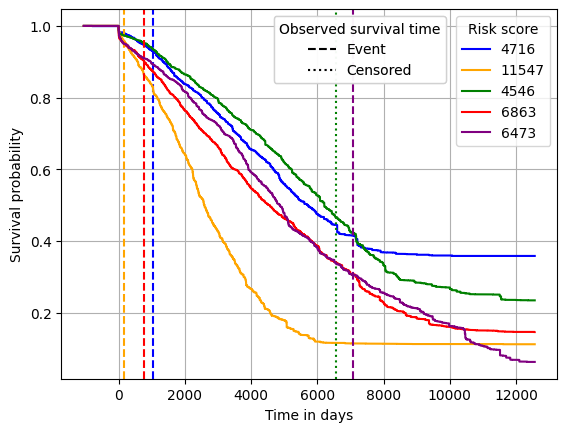

In [29]:
surv = rsf.predict_survival_function(random_features, return_array=True)
lines = []
labels = risk.astype(int).tolist()
for i, s in enumerate(surv):
    # plt.step(rsf.unique_times_, s, where="post",color=colors[i] ,label=int(risk[i]))
    line  = plt.step(rsf.unique_times_, s, where="post",color=colors[i])
    lines.append(line[0])
    if random_targets[i]['event']:
        plt.axvline(x=random_targets[i]['time'], color=colors[i] ,linestyle='--')
    else:
        plt.axvline(x=random_targets[i]['time'], color=colors[i], linestyle=':')
              
legend1 = plt.legend(lines, labels, loc='upper right',  bbox_to_anchor=(1.0, 1.0))
legend1.set_title('Risk score')        
        
event_line = Line2D([], [], color='black', linestyle='--', label='Event')
censoring_line = Line2D([], [], color='black', linestyle=':', label='Censored')


legend2 = plt.legend(handles=[event_line, censoring_line], loc='upper right',bbox_to_anchor=(0.79, 1.0))
legend2.set_title('Observed survival time')

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.ylabel("Survival probability")
plt.xlabel("Time in days")
#plt.legend(title="Risk score")
plt.grid(True)
#plt.savefig("plots/surv_example_no_title_obslegend.pdf", format="pdf")

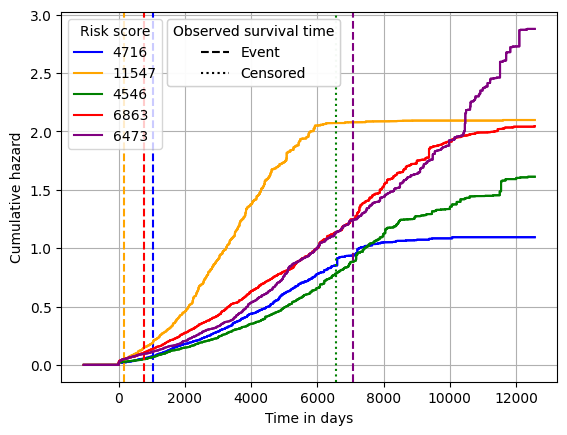

In [30]:
hazard = rsf.predict_cumulative_hazard_function(random_features, return_array=True)
hazard_lines = []

for i, s in enumerate(hazard):
    plt.step(rsf.unique_times_, s, where="post",color=colors[i] ,label=int(risk[i]))
    hazard_line  = plt.step(rsf.unique_times_, s, where="post",color=colors[i])
    hazard_lines.append(hazard_line[0])
    if random_targets[i]['event']:
        plt.axvline(x=random_targets[i]['time'], color=colors[i] ,linestyle='--')
    else:
        plt.axvline(x=random_targets[i]['time'], color=colors[i], linestyle=':')
        
legend1 = plt.legend(lines, labels, loc='upper left',  bbox_to_anchor=(0.0, 1.0))
legend1.set_title('Risk score')  

event_line = Line2D([], [], color='black', linestyle='--', label='Event')
censoring_line = Line2D([], [], color='black', linestyle=':', label='Censored')

legend2 = plt.legend(handles=[event_line, censoring_line], loc='upper left',bbox_to_anchor=(0.2, 1.0))
legend2.set_title('Observed survival time')

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
        
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.grid(True)
#plt.savefig("plots/hazard_example_no_title_obslegend.pdf", format="pdf")

#### Comparison to Cox Regression

In [31]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

/mnt/lustre/helios-home/kloucmat/my_virtual_env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.43346e-24): result may not be accurate.
  delta = solve(
/mnt/lustre/helios-home/kloucmat/my_virtual_env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=4.53508e-23): result may not be accurate.
  delta = solve(
/mnt/lustre/helios-home/kloucmat/my_virtual_env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=7.51134e-23): result may not be accurate.
  delta = solve(
/mnt/lustre/helios-home/kloucmat/my_virtual_env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=4.52684e-24): result may not be accurate.
  delta = solve(


CoxPHSurvivalAnalysis()

In [32]:
pd.Series(estimator.coef_, index=X_train.columns)

CREAT_TRR                    0.000902
AGE                          0.004366
AGE_DON                      0.008629
END_BMI_CALC                 0.008738
DAYSWAIT_CHRON_KI           -0.000060
TOT_SERUM_ALBUM             -0.111049
HLAMIS                       0.062165
DAYSWAIT_ALLOC               0.000054
KI_CREAT_PREOP               0.006211
PREV_TX_ANY_N              -26.673279
PREV_TX_ANY_Y              -26.538188
ON_DIALYSIS_1               33.006680
ON_DIALYSIS_N               32.524889
ON_DIALYSIS_Y               32.685984
DIAB_1.0                  -170.518124
DIAB_2.0                  -170.474223
DIAB_3.0                  -170.328454
DIAB_4.0                  -170.406682
DIAB_5.0                  -170.494564
DIAB_998.0                -170.569458
WORK_INCOME_TCR_N           -6.560195
WORK_INCOME_TCR_U           -6.688356
WORK_INCOME_TCR_Y           -6.648102
PRI_PAYMENT_TCR_KI_1.0      13.177199
PRI_PAYMENT_TCR_KI_2.0      13.367628
PRI_PAYMENT_TCR_KI_3.0      13.446662
PRI_PAYMENT_

In [33]:
estimator.score(X_test, y_test)

0.6209973927098117

#### Graphs for investigating recipient's age

In [34]:
y_test_df = pd.DataFrame(y_test)
y_test_df

,event,time
0,False,1076.0
1,False,713.0
2,False,1095.0
3,False,1809.0
4,False,363.0
...,...,...
26051,False,732.0
26052,False,2562.0
26053,False,4345.0
26054,True,1471.0


In [35]:
X_test_reindexed = X_test.reset_index(drop=True)
X_test_reindexed

,CREAT_TRR,AGE,AGE_DON,END_BMI_CALC,DAYSWAIT_CHRON_KI,TOT_SERUM_ALBUM,HLAMIS,DAYSWAIT_ALLOC,KI_CREAT_PREOP,PREV_TX_ANY_N,PREV_TX_ANY_Y,ON_DIALYSIS_1,ON_DIALYSIS_N,ON_DIALYSIS_Y,DIAB_1.0,DIAB_2.0,DIAB_3.0,DIAB_4.0,DIAB_5.0,DIAB_998.0,WORK_INCOME_TCR_N,WORK_INCOME_TCR_U,WORK_INCOME_TCR_Y,PRI_PAYMENT_TCR_KI_1.0,PRI_PAYMENT_TCR_KI_2.0,PRI_PAYMENT_TCR_KI_3.0,PRI_PAYMENT_TCR_KI_4.0,PRI_PAYMENT_TCR_KI_5.0,PRI_PAYMENT_TCR_KI_6.0,PRI_PAYMENT_TCR_KI_7.0,PRI_PAYMENT_TCR_KI_8.0,PRI_PAYMENT_TCR_KI_9.0,PRI_PAYMENT_TCR_KI_10.0,PRI_PAYMENT_TCR_KI_11.0,PRI_PAYMENT_TCR_KI_12.0,PRI_PAYMENT_TCR_KI_13.0,PRI_PAYMENT_TCR_KI_14.0,PRE_TX_TXFUS_N,PRE_TX_TXFUS_U,PRE_TX_TXFUS_Y,PERIP_VASC_N,PERIP_VASC_U,PERIP_VASC_Y,ETHCAT_DON_1,ETHCAT_DON_2,ETHCAT_DON_4,ETHCAT_DON_5,ETHCAT_DON_6,ETHCAT_DON_7,ETHCAT_DON_9,ETHCAT_DON_998,ETHCAT_1,ETHCAT_2,ETHCAT_4,ETHCAT_5,ETHCAT_6,ETHCAT_7,ETHCAT_9,ETHCAT_998,FUNC_STAT_TCR_1.0,FUNC_STAT_TCR_2.0,FUNC_STAT_TCR_3.0,FUNC_STAT_TCR_996.0,FUNC_STAT_TCR_998.0,FUNC_STAT_TCR_2010.0,FUNC_STAT_TCR_2020.0,FUNC_STAT_TCR_2030.0,FUNC_STAT_TCR_2040.0,FUNC_STAT_TCR_2050.0,FUNC_STAT_TCR_2060.0,FUNC_STAT_TCR_2070.0,FUNC_STAT_TCR_2080.0,FUNC_STAT_TCR_2090.0,FUNC_STAT_TCR_2100.0,FUNC_STAT_TCR_4010.0,FUNC_STAT_TCR_4020.0,FUNC_STAT_TCR_4030.0,FUNC_STAT_TCR_4040.0,FUNC_STAT_TCR_4050.0,FUNC_STAT_TCR_4060.0,FUNC_STAT_TCR_4070.0,FUNC_STAT_TCR_4080.0,FUNC_STAT_TCR_4090.0,FUNC_STAT_TCR_4100.0,HCV_SEROSTATUS_N,HCV_SEROSTATUS_ND,HCV_SEROSTATUS_P,HCV_SEROSTATUS_U,HIST_CIG_N,HIST_CIG_Y,EBV_SEROSTATUS_N,EBV_SEROSTATUS_ND,EBV_SEROSTATUS_P,EBV_SEROSTATUS_U,DIABETES_DON_N,DIABETES_DON_U,DIABETES_DON_Y,DIAG_KI_999.0,DIAG_KI_3000.0,DIAG_KI_3001.0,DIAG_KI_3002.0,DIAG_KI_3003.0,DIAG_KI_3004.0,DIAG_KI_3005.0,DIAG_KI_3006.0,DIAG_KI_3007.0,DIAG_KI_3008.0,DIAG_KI_3009.0,DIAG_KI_3010.0,DIAG_KI_3011.0,DIAG_KI_3012.0,DIAG_KI_3013.0,DIAG_KI_3014.0,DIAG_KI_3015.0,DIAG_KI_3016.0,DIAG_KI_3017.0,DIAG_KI_3018.0,DIAG_KI_3019.0,DIAG_KI_3020.0,DIAG_KI_3021.0,DIAG_KI_3022.0,DIAG_KI_3023.0,DIAG_KI_3024.0,DIAG_KI_3025.0,DIAG_KI_3026.0,DIAG_KI_3027.0,DIAG_KI_3028.0,DIAG_KI_3029.0,DIAG_KI_3030.0,DIAG_KI_3031.0,DIAG_KI_3032.0,DIAG_KI_3033.0,DIAG_KI_3034.0,DIAG_KI_3035.0,DIAG_KI_3036.0,DIAG_KI_3037.0,DIAG_KI_3038.0,DIAG_KI_3039.0,DIAG_KI_3040.0,DIAG_KI_3041.0,DIAG_KI_3042.0,DIAG_KI_3043.0,DIAG_KI_3044.0,DIAG_KI_3045.0,DIAG_KI_3046.0,DIAG_KI_3047.0,DIAG_KI_3048.0,DIAG_KI_3049.0,DIAG_KI_3050.0,DIAG_KI_3051.0,DIAG_KI_3052.0,DIAG_KI_3053.0,DIAG_KI_3054.0,DIAG_KI_3055.0,DIAG_KI_3056.0,DIAG_KI_3057.0,DIAG_KI_3058.0,DIAG_KI_3059.0,DIAG_KI_3060.0,DIAG_KI_3061.0,DIAG_KI_3062.0,DIAG_KI_3063.0,DIAG_KI_3064.0,DIAG_KI_3066.0,DIAG_KI_3068.0,DIAG_KI_3069.0,DIAG_KI_3070.0,DIAG_KI_3071.0,DIAG_KI_3072.0,DIAG_KI_3073.0,DIAG_KI_3074.0
0,6.060000,73.0,64.0,30.500000,693.000000,2.800000,5.0,887.000000,0.66000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,6.400000,46.0,50.0,26.500000,40.000000,4.000000,2.0,40.000000,0.80000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [36]:
merged_test = X_test_reindexed.join(y_test_df)
merged_test

,CREAT_TRR,AGE,AGE_DON,END_BMI_CALC,DAYSWAIT_CHRON_KI,TOT_SERUM_ALBUM,HLAMIS,DAYSWAIT_ALLOC,KI_CREAT_PREOP,PREV_TX_ANY_N,PREV_TX_ANY_Y,ON_DIALYSIS_1,ON_DIALYSIS_N,ON_DIALYSIS_Y,DIAB_1.0,DIAB_2.0,DIAB_3.0,DIAB_4.0,DIAB_5.0,DIAB_998.0,WORK_INCOME_TCR_N,WORK_INCOME_TCR_U,WORK_INCOME_TCR_Y,PRI_PAYMENT_TCR_KI_1.0,PRI_PAYMENT_TCR_KI_2.0,PRI_PAYMENT_TCR_KI_3.0,PRI_PAYMENT_TCR_KI_4.0,PRI_PAYMENT_TCR_KI_5.0,PRI_PAYMENT_TCR_KI_6.0,PRI_PAYMENT_TCR_KI_7.0,PRI_PAYMENT_TCR_KI_8.0,PRI_PAYMENT_TCR_KI_9.0,PRI_PAYMENT_TCR_KI_10.0,PRI_PAYMENT_TCR_KI_11.0,PRI_PAYMENT_TCR_KI_12.0,PRI_PAYMENT_TCR_KI_13.0,PRI_PAYMENT_TCR_KI_14.0,PRE_TX_TXFUS_N,PRE_TX_TXFUS_U,PRE_TX_TXFUS_Y,PERIP_VASC_N,PERIP_VASC_U,PERIP_VASC_Y,ETHCAT_DON_1,ETHCAT_DON_2,ETHCAT_DON_4,ETHCAT_DON_5,ETHCAT_DON_6,ETHCAT_DON_7,ETHCAT_DON_9,ETHCAT_DON_998,ETHCAT_1,ETHCAT_2,ETHCAT_4,ETHCAT_5,ETHCAT_6,ETHCAT_7,ETHCAT_9,ETHCAT_998,FUNC_STAT_TCR_1.0,FUNC_STAT_TCR_2.0,FUNC_STAT_TCR_3.0,FUNC_STAT_TCR_996.0,FUNC_STAT_TCR_998.0,FUNC_STAT_TCR_2010.0,FUNC_STAT_TCR_2020.0,FUNC_STAT_TCR_2030.0,FUNC_STAT_TCR_2040.0,FUNC_STAT_TCR_2050.0,FUNC_STAT_TCR_2060.0,FUNC_STAT_TCR_2070.0,FUNC_STAT_TCR_2080.0,FUNC_STAT_TCR_2090.0,FUNC_STAT_TCR_2100.0,FUNC_STAT_TCR_4010.0,FUNC_STAT_TCR_4020.0,FUNC_STAT_TCR_4030.0,FUNC_STAT_TCR_4040.0,FUNC_STAT_TCR_4050.0,FUNC_STAT_TCR_4060.0,FUNC_STAT_TCR_4070.0,FUNC_STAT_TCR_4080.0,FUNC_STAT_TCR_4090.0,FUNC_STAT_TCR_4100.0,HCV_SEROSTATUS_N,HCV_SEROSTATUS_ND,HCV_SEROSTATUS_P,HCV_SEROSTATUS_U,HIST_CIG_N,HIST_CIG_Y,EBV_SEROSTATUS_N,EBV_SEROSTATUS_ND,EBV_SEROSTATUS_P,EBV_SEROSTATUS_U,DIABETES_DON_N,DIABETES_DON_U,DIABETES_DON_Y,DIAG_KI_999.0,DIAG_KI_3000.0,DIAG_KI_3001.0,DIAG_KI_3002.0,DIAG_KI_3003.0,DIAG_KI_3004.0,DIAG_KI_3005.0,DIAG_KI_3006.0,DIAG_KI_3007.0,DIAG_KI_3008.0,DIAG_KI_3009.0,DIAG_KI_3010.0,DIAG_KI_3011.0,DIAG_KI_3012.0,DIAG_KI_3013.0,DIAG_KI_3014.0,DIAG_KI_3015.0,DIAG_KI_3016.0,DIAG_KI_3017.0,DIAG_KI_3018.0,DIAG_KI_3019.0,DIAG_KI_3020.0,DIAG_KI_3021.0,DIAG_KI_3022.0,DIAG_KI_3023.0,DIAG_KI_3024.0,DIAG_KI_3025.0,DIAG_KI_3026.0,DIAG_KI_3027.0,DIAG_KI_3028.0,DIAG_KI_3029.0,DIAG_KI_3030.0,DIAG_KI_3031.0,DIAG_KI_3032.0,DIAG_KI_3033.0,DIAG_KI_3034.0,DIAG_KI_3035.0,DIAG_KI_3036.0,DIAG_KI_3037.0,DIAG_KI_3038.0,DIAG_KI_3039.0,DIAG_KI_3040.0,DIAG_KI_3041.0,DIAG_KI_3042.0,DIAG_KI_3043.0,DIAG_KI_3044.0,DIAG_KI_3045.0,DIAG_KI_3046.0,DIAG_KI_3047.0,DIAG_KI_3048.0,DIAG_KI_3049.0,DIAG_KI_3050.0,DIAG_KI_3051.0,DIAG_KI_3052.0,DIAG_KI_3053.0,DIAG_KI_3054.0,DIAG_KI_3055.0,DIAG_KI_3056.0,DIAG_KI_3057.0,DIAG_KI_3058.0,DIAG_KI_3059.0,DIAG_KI_3060.0,DIAG_KI_3061.0,DIAG_KI_3062.0,DIAG_KI_3063.0,DIAG_KI_3064.0,DIAG_KI_3066.0,DIAG_KI_3068.0,DIAG_KI_3069.0,DIAG_KI_3070.0,DIAG_KI_3071.0,DIAG_KI_3072.0,DIAG_KI_3073.0,DIAG_KI_3074.0,event,time
0,6.060000,73.0,64.0,30.500000,693.000000,2.800000,5.0,887.000000,0.66000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False,1076.0
1,6.400000,46.0,50.0,26.500000,40.000000,4.000000,2.0,40.000000,0.80000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [37]:
age_intervals = pd.IntervalIndex.from_tuples([(0, 15), (15, 30), (30, 45), (45, 60), (60, 75)], closed='left')
# age_intervals = pd.IntervalIndex.from_tuples([(0, 60), (60, 75)], closed='left')

In [38]:
samples = {}

for age_group in age_intervals:
    group_name = f'{age_group.left}-{age_group.right - 1}'
    group_data = merged_test.loc[merged_test['AGE'].between(age_group.left, age_group.right - 1)]
    samples[group_name] = group_data.sample(n=1000, replace=True).to_dict(orient='records')
    
    
sample_dfs = []
group_names = []
for group_name, group_data in samples.items():
    df = pd.DataFrame.from_dict(group_data)
    sample_dfs.append(df)
    group_names.append(group_name)

group_names

['0-14', '15-29', '30-44', '45-59', '60-74']

In [39]:
y_sample_dfs = []
X_sample_dfs = []
for group_df in sample_dfs:
    y_sample_dfs.append(group_df[['event', 'time']])
    X_sample_dfs.append(group_df.drop(['event', 'time'], axis=1))
    
y_sample_dfs[0]

,event,time
0,False,9126.0
1,True,0.0
2,False,2416.0
3,False,104.0
4,False,391.0
...,...,...
995,False,2904.0
996,False,3990.0
997,False,5789.0
998,True,2943.0


In [ ]:
averaged_risk_scores = []
for group_df in X_sample_dfs:
    risk = rsf.predict(group_df)
    average_risk = np.mean(risk, axis=0)
    averaged_risk_scores.append(average_risk)
    
print(f"{averaged_risk_scores[1]}-{averaged_risk_scores[0]}={averaged_risk_scores[1]-averaged_risk_scores[0]}")

In [ ]:
averaged_survival_functions = []
for group_df in X_sample_dfs:
    surv = rsf.predict_survival_function(group_df, return_array=True)
    average_surv = np.mean(surv, axis=0)
    averaged_survival_functions.append(average_surv)
    
averaged_survival_functions

In [ ]:
fig, ax = plt.subplots()

for index, function in enumerate(averaged_survival_functions):
    ax.step(rsf.unique_times_, function, where="post", label=group_names[index])

ax.set_ylabel("Survival probability")
ax.set_xlabel("Time in days")
ax.legend(title='Recipient age')
ax.set_ylim(0, 1.1)
#ax.set_title("Averaged survival curves predicted by RSF")
ax.grid(True)
# fig.savefig("plots/RSF_average_age.pdf", format='pdf')

In [ ]:
kaplan_meier_curves = []
for y_sample in y_sample_dfs:
    time, survival_prob = kaplan_meier_estimator(y_sample["event"], y_sample["time"])
    kaplan_meier_curves.append([time, survival_prob])


In [ ]:
fig, ax = plt.subplots()

for index, kaplan_meier_curve in enumerate(kaplan_meier_curves):
    ax.step(kaplan_meier_curve[0], kaplan_meier_curve[1], where="post", label=group_names[index])

ax.set_ylabel("Survival probability")
ax.set_xlabel("Time in days")
ax.legend(title='Recipient age')
ax.set_ylim(0, 1.1)
#ax.set_title("Survival curves computed by Kaplan-Meier estimator")
ax.grid(True)
#fig.savefig("plots/KaplanMeier_test_average_age.pdf", format='pdf')

#### Graphs for ethnic categories

In [ ]:
y_df = pd.DataFrame(y_struct)
ethcat_df = final_kidpan_living[['ETHCAT', 'ETHCAT_DON']]
merged = ethcat_df.join(y_df)
merged

In [ ]:
dropped_ethcat = merged[(final_kidpan_living['ETHCAT'] != 998) & (merged['ETHCAT_DON'] != 998)]
replacement_dict = {1: 'white', 2: 'black', 4: 'hispanic', 5: 'asian', 6: 'native american', 
                    7: 'Pacific islander', 9: 'multiracial' }
dropped_ethcat['ETHCAT'] = dropped_ethcat['ETHCAT'].replace(replacement_dict)
dropped_ethcat['ETHCAT_DON'] = dropped_ethcat['ETHCAT_DON'].replace(replacement_dict)
dropped_ethcat

In [ ]:
subsets = dropped_ethcat.groupby(['ETHCAT', 'ETHCAT_DON'])

subset_sizes = subsets.size()
sorted_subsets = subset_sizes.sort_values(ascending=False)


In [ ]:
top_subsets = sorted_subsets.head(10)

In [ ]:
fig, ax = plt.subplots()

for (recipient, donor), _ in top_subsets.items():
    subset = subsets.get_group((recipient, donor))
    time, survival_prob = kaplan_meier_estimator(subset["event"], subset["time"])
    ax.step(time, survival_prob, where="post", label=f"{recipient}-{donor}")
    
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time in days")
ax.set_xlim(-500, 13000)
ax.legend(title='Ethnicity')
ax.grid(True)
# plt.savefig("plots/kaplan_meier_ethnicity.pdf", format="pdf")

In [ ]:
subsets = []
for i in [1,2,4,5]:
    temp = X_test.loc[(X_test[f'ETHCAT_{i}'] == 1) & (X_test[f"ETHCAT_{i}"] == 1)]
    subsets.append(temp)

subsets[0]

In [ ]:
averaged_survival_functions = []
for subset in subsets:
    surv = rsf.predict_survival_function(subset, return_array=True)
    average_surv = np.mean(surv, axis=0)
    averaged_survival_functions.append(average_surv)
    
averaged_survival_functions

In [ ]:
fig, ax = plt.subplots()
labels = ["white", "black", "hispanic", "asian"]

for index, function in enumerate(averaged_survival_functions):
    ax.step(rsf.unique_times_, function, where="post", label=f"{labels[index]}-{labels[index]}")

ax.set_ylabel("Survival probability")
ax.set_xlabel("Time in days")
ax.legend(title='HLAMIS')
ax.set_ylim(0, 1.1)
ax.grid(True)

fig.savefig("plots/RSF_average_ethcat.pdf", format='pdf')

#### Graphs for HLA mismatch

In [ ]:
y_df = pd.DataFrame(y_struct)
hlamis_df = final_kidpan_living[['HLAMIS']]
merged = hlamis_df.join(y_df)
merged

In [ ]:
dropped_hlamis = merged.dropna(axis=0)
dropped_hlamis

In [ ]:
subsets = []
for i in range (0,6):
    temp = dropped_hlamis.loc[dropped_hlamis['HLAMIS'] == i]
    subsets.append(temp)

subsets[0]

In [ ]:
fig, ax = plt.subplots()

for index, subset in enumerate(subsets):
    print(index)
    time, survival_prob = kaplan_meier_estimator(subset["event"], subset["time"])
    ax.step(time, survival_prob, where="post", label=index)
    
ax.set_ylabel("Survival probability")
ax.set_xlabel("Time in days")
ax.set_xlim(-500, 13000)
ax.legend(title='HLAMIS')
ax.grid(True)
# plt.savefig("plots/kaplan_meier_hlamis.pdf", format="pdf")

In [ ]:
subsets = []
for i in range (0,6):
    temp = X_test.loc[X_test['ETH_CAT'] == i]
    subsets.append(temp)

subsets[0]

In [ ]:
averaged_survival_functions = []
for subset in subsets:
    surv = rsf.predict_survival_function(subset, return_array=True)
    average_surv = np.mean(surv, axis=0)
    averaged_survival_functions.append(average_surv)
    
averaged_survival_functions

In [ ]:
fig, ax = plt.subplots()

for index, function in enumerate(averaged_survival_functions):
    ax.step(rsf.unique_times_, function, where="post", label=index)

ax.set_ylabel("Survival probability")
ax.set_xlabel("Time in days")
ax.legend(title='HLAMIS')
ax.set_ylim(0, 1.1)
ax.grid(True)

# fig.savefig("plots/RSF_average_hlamis.pdf", format='pdf')

#### Rate of censoring

In [ ]:
censored_data = y[y['GSTATUS_KI'] == 0]
event_data = y[y['GSTATUS_KI'] == 1]
bin_width = 1000
print(len(censored_data )/ (len(censored_data) + len(event_data)))

In [ ]:
plt.hist(censored_data['GTIME_KI'], bins=int((y['GTIME_KI'].max() - y['GTIME_KI'].min()) / bin_width), color='red', alpha=0.5, label='Censored')# Set plot title and axis labels
plt.hist(event_data['GTIME_KI'], bins=int((y['GTIME_KI'].max() - y['GTIME_KI'].min()) / bin_width), color='green', alpha=0.5, label='Event Occurrence')
plt.title('Censoring Distribution Histogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Computing risk score - example

In [ ]:
X_test_before_encoding = numerical_imputed_X_test.merge(categorical_imputed_X_test, left_index=True, right_index=True)

In [ ]:
random_index = np.random.choice(X_test.shape[0])

In [ ]:
original_row = X_test_before_encoding.iloc[[random_index]]
original_row

In [ ]:
row = original_row.copy()
patient_columns = ['CREAT_TRR', 'AGE', 'END_BMI_CALC', 'DAYSWAIT_CHRON_KI', 'TOT_SERUM_ALBUM', 'DAYSWAIT_ALLOC', 'PREV_TX_ANY',
              'ON_DIALYSIS', 'DIAB', 'WORK_INCOME_TCR', 'PRI_PAYMENT_TCR_KI', 'PRE_TX_TXFUS', 'PERIP_VASC', 'ETHCAT',
               'FUNC_STAT_TCR', 'HCV_SEROSTATUS', 'HIST_CIG', 'EBV_SEROSTATUS', 'DIAG_KI']
patient = row[patient_columns]
patient

In [ ]:
vertical_table = pd.melt(patient, var_name='Column', value_name='Value')
vertical_table

In [ ]:
print(vertical_table.to_latex(index=False))

In [ ]:
num_rows = 5

# Select random row indices from the one-hot encoded test set
random_indices = np.random.choice(X_test.shape[0], size=num_rows, replace=False)

# Get the corresponding rows from the original dataset as a DataFrame
original_rows = X_test_before_encoding.iloc[random_indices]
original_rows

In [ ]:
rows = original_rows.copy()
donor_columns = [x for x in rows.columns.tolist() if x not in patient_columns]
donors_og = rows[donor_columns]
donors = donors_og.reset_index(drop=True)
donors[['AGE_DON', 'DRMIS', 'AMIS', 'BMIS', 'HLAMIS']] = donors[['AGE_DON', 'DRMIS', 'AMIS', 'BMIS', 'HLAMIS']].astype(int)
donors

In [ ]:
print(donors.to_latex())

In [ ]:
encoded_donors_whole_rows = X_test.iloc[random_indices]
encoded_donors_whole_rows

In [ ]:
patient_multiple = pd.concat([patient, patient, patient, patient, patient])
patient

In [ ]:
example_test = pd.concat([patient_multiple.reset_index(drop=True), donors_og.reset_index(drop=True)], axis=1)
example_test = example_test[X.columns]
example_test

In [ ]:
right_columns = X_test_og[categorical_cols].columns.tolist()
X_test_og[categorical_cols]

In [ ]:
example_test_categorical = example_test[right_columns]
example_test_categorical

In [ ]:
encoded_example_array = enc.transform(example_test[right_columns])
encoded_example_columns = enc.get_feature_names_out(example_test_categorical.columns)
encoded_example = pd.DataFrame(encoded_example_array, columns=encoded_example_columns)
encoded_example

In [ ]:
numerical_example = example_test[numerical_cols]
numerical_example

In [ ]:
example = numerical_example.merge(encoded_example, left_index=True, right_index=True)
example

In [ ]:
risks_ex = rsf.predict(example)
risks_ex